In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Load your data
data = pd.read_csv('unique_IDs_csv/34102.csv')

# data = data.drop(columns=['ID'])

# Convert relevant columns to numeric, coercing errors to NaN
numeric_columns = ['GameFormat', 'SR', 'BattingInnings', 'IsOut', 'isTossWon', 
                   'Fantasy', 'isHomeGround', 'GroundWL', 'GroundRPO', 
                   'GroundAvg', 'TossWL', 'TossRPO', 'TossAvg', 
                   'inningsWL', 'inningsRPO', 'inningsAverage', 
                   'Average', 'Innings', 'Centuries', 'Fifties', 
                   'Zeros', 'Consistency', 'Form', 'Opps', 
                   'MaxTemp', 'MinTemp', 'RainProb', 'MaxWind', 
                   'BattingOrder']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')
# Normalize the features
# scaler = MinMaxScaler()
# data[numeric_columns] = scaler.fit_transform(data[numeric_columns])



# Apply label encoding to categorical columns
categorical_columns = ['GameFormat', 'Opposition', 'Ground', 'TossResult', 'MatchTime', 'Venue', 'Tournament']
encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    encoders[col] = le  # Store the encoder for the column

data = data.drop(columns=['ID', 'MatchDate'])


In [15]:
data

,GameFormat,SR,BattingInnings,IsOut,Opposition,Ground,TossResult,MatchTime,isTossWon,Fantasy,...,Form,Venue,Opps,MaxTemp,MinTemp,RainProb,MaxWind,WeatherCode,Tournament,BattingOrder
0,1,0.000000,2,0,3,66,1,0,1,74,...,0.9353,0,1.0927,37.8,24.7,0.0,19.2,0.0,5,2
1,1,108.108108,2,0,12,7,0,0,0,233,...,3.2441,0,1.0927,38.8,24.2,0.0,17.1,0.0,5,2
2,1,171.951220,1,1,34,66,0,0,1,23,...,3.2441,58,1.0927,39.2,25.3,0.0,15.6,0.0,5,2
3,1,165.591398,2,1,24,7,1,0,1,40,...,3.2441,55,1.0927,35.0,24.7,0.0,15.4,3.0,5,2
4,1,165.384615,2,1,43,2,1,1,1,43,...,3.2441,0,1.0927,40.5,26.0,0.0,13.4,2.0,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,0,135.985534,1,1,1,28,1,0,0,202,...,3.0745,57,3.7423,30.4,25.7,3.5,29.6,55.0,6,1
579,0,136.296550,1,1,9,56,1,0,0,111,...,3.5007,0,4.1360,28.2,24.7,5.8,14.0,63.0,6,1
580,1,136.329428,1,1,9,56,1,0,0,111,...,3.5563,57,4.1916,28.2,24.7,5.8,14.0,63.0,6,1
581,0,136.362087,1,1,39,8,0,0,1,27,...,3.5563,94,3.7098,31.3,25.6,2.8,30.0,61.0,6,1


In [16]:
# Prepare sequences
def prepare_sequences(data, sequence_length=10):

    # Select relevant features for input (excluding 'Fantasy' and 'MatchDate')
    features = data.drop(columns=['Fantasy']).values
    target = data['Fantasy'].values

    X, y = [], []
    
    for i in range(len(features) - sequence_length):
        # Create a sequence of features
        X.append(features[i:i + sequence_length])
        # The target is the value of 'Fantasy' at the end of the sequence
        y.append(target[i + sequence_length])
    
    return np.array(X), np.array(y)

# Preprocess your data
X, y = prepare_sequences(data)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the LSTM model with ReLU activation in the output layer
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, activation='relu'))  # Add another LSTM layer
model.add(Dense(1, activation='relu'))  # Use ReLU activation to bound outputs to non-negative values
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(X_train, y_train, epochs=200, verbose=0)

/Users/ghazalaamin/Documents/Dream-11-Fantasy-Points-Prediction/dream_11_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
import tensorflow as tf

# Custom activation function to bound outputs between 50 and 150
def bounded_activation(x):
    return 50 + (100 * tf.nn.relu(x))  # Scale output to [50, 150]

# Define the LSTM model with custom activation in the output layer
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, activation='relu'))  # Add another LSTM layer
model.add(Dense(1, activation=bounded_activation))  # Use custom activation to bound outputs
model.compile(optimizer='adam', loss='mse')

/Users/ghazalaamin/Documents/Dream-11-Fantasy-Points-Prediction/dream_11_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Mean Squared Error on Test Set: 18041364.0


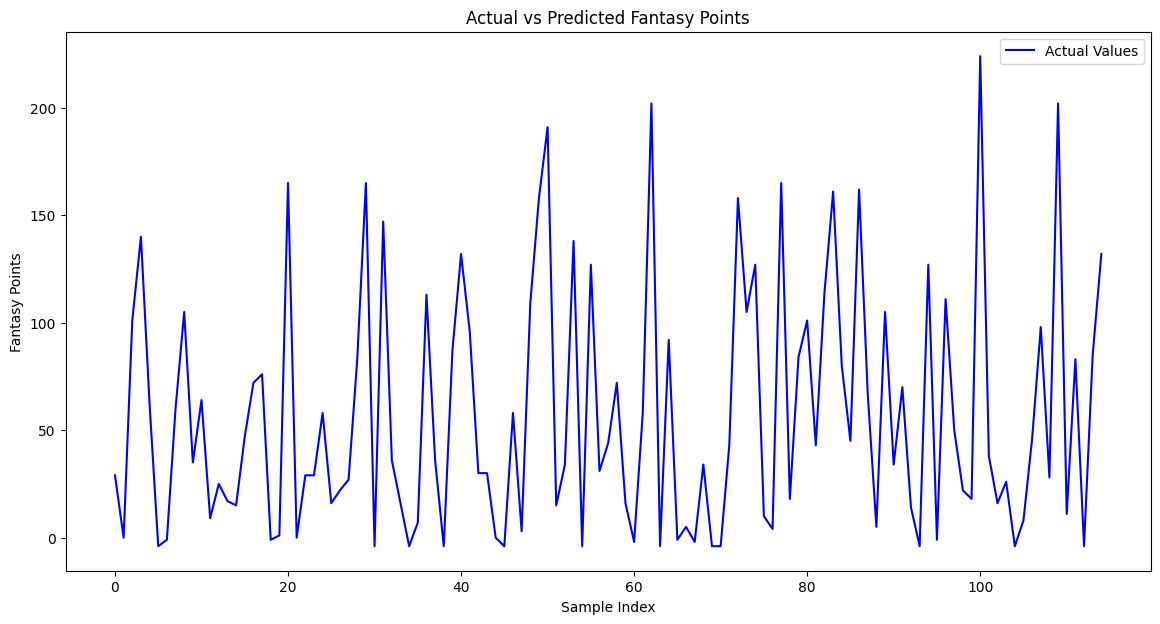

In [20]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Values', color='blue')
# plt.plot(y_pred, label='Predicted Values', color='orange')
plt.title('Actual vs Predicted Fantasy Points')
plt.xlabel('Sample Index')
plt.ylabel('Fantasy Points')
plt.legend()
plt.show()